In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
movies = pd.read_csv("movies.csv")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [5]:
ratings = pd.read_csv("ratings.csv")
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [6]:
tags = pd.read_csv("tags.csv")
tags.columns

Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')

In [7]:
links = pd.read_csv("links.csv")
links.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [8]:
#Clean the data
#clean null values
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
tags.dropna(inplace=True)
links.dropna(inplace=True)

# Merge movies + tags
tags_agg = tags.groupby('movieId')['tag'].apply(lambda x: " ".join(x)).reset_index()
movies_tags = pd.merge(movies, tags_agg, on='movieId', how='left')

print(movies_tags.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                            tag  
0                               pixar pixar fun  
1  fantasy magic board game Robin Williams game  
2                                     moldy old  
3                                           NaN  
4                              pregnancy remake  


In [9]:
#Analyze Popular Movies
movie_ratings = pd.merge(ratings, movies, on='movieId')
popularity = movie_ratings.groupby('title')['rating'].count().reset_index()
popularity.rename(columns={'rating': 'num_ratings'}, inplace=True)
top10_popular = popularity.sort_values(by='num_ratings', ascending=False).head(10)
print(top10_popular)


                                          title  num_ratings
3158                        Forrest Gump (1994)          329
7593           Shawshank Redemption, The (1994)          317
6865                        Pulp Fiction (1994)          307
7680           Silence of the Lambs, The (1991)          279
5512                         Matrix, The (1999)          278
8001  Star Wars: Episode IV - A New Hope (1977)          251
4662                       Jurassic Park (1993)          238
1337                          Braveheart (1995)          237
8363          Terminator 2: Judgment Day (1991)          224
7421                    Schindler's List (1993)          220


In [10]:
#Analyze Top-Rated Movies
avg_rating = movie_ratings.groupby('title')['rating'].mean().reset_index()
avg_rating.rename(columns={'rating': 'avg_rating'}, inplace=True)

summary = pd.merge(popularity, avg_rating, on='title')
filtered = summary[summary['num_ratings'] >= 50]
top10_best = filtered.sort_values(by='avg_rating', ascending=False).head(10)
print(top10_best)


                                                  title  num_ratings  \
7593                   Shawshank Redemption, The (1994)          317   
3499                              Godfather, The (1972)          192   
3011                                  Fight Club (1999)          218   
1961                              Cool Hand Luke (1967)           57   
2531  Dr. Strangelove or: How I Learned to Stop Worr...           97   
6999                                 Rear Window (1954)           84   
3500                     Godfather: Part II, The (1974)          129   
2334                               Departed, The (2006)          107   
3564                                  Goodfellas (1990)          126   
1593                                  Casablanca (1942)          100   

      avg_rating  
7593    4.429022  
3499    4.289062  
3011    4.272936  
1961    4.271930  
2531    4.268041  
6999    4.261905  
3500    4.259690  
2334    4.252336  
3564    4.250000  
1593    4.240000 

In [11]:
# Combine text features
movies_tags['content'] = movies_tags['genres'] + " " + movies_tags['tag'].fillna("")

# Vectorize
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_tags['content'])

# Compute similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [12]:
#Create Recommendation Function
def recommend_movie(title, cosine_sim=cosine_sim):
    # case-insensitive match
    matches = movies_tags[movies_tags['title'].str.lower() == title.lower()]
    
    if matches.empty:
        print(f" '{title}' not found! Try searching like this:")
        suggestions = movies_tags[movies_tags['title'].str.contains(title.split()[0], case=False, na=False)]
        print(suggestions['title'].head(5).to_list())
        return []
    
    idx = matches.index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies_tags['title'].iloc[movie_indices].to_list()


In [13]:
#Test the Recommendation System
print("Similar movies to 'Inception (2010)':")
print(recommend_movie("Inception (2010)"))

print("\nSimilar movies to 'The Matrix (1999)':")
print(recommend_movie("The Matrix (1995)"))



Similar movies to 'Inception (2010)':
['Eye in the Sky (2016)', 'Donnie Darko (2001)', 'Doctor Strange (2016)', 'Arrival (2016)', 'Gattaca (1997)', 'Shutter Island (2010)', 'Primal Fear (1996)', 'Eternal Sunshine of the Spotless Mind (2004)', 'Interstellar (2014)', 'Silence (2016)']

Similar movies to 'The Matrix (1999)':
 'The Matrix (1995)' not found! Try searching like this:
['Father of the Bride Part II (1995)', 'American President, The (1995)', 'Othello (1995)', 'Now and Then (1995)', 'City of Lost Children, The (Cité des enfants perdus, La) (1995)']
[]


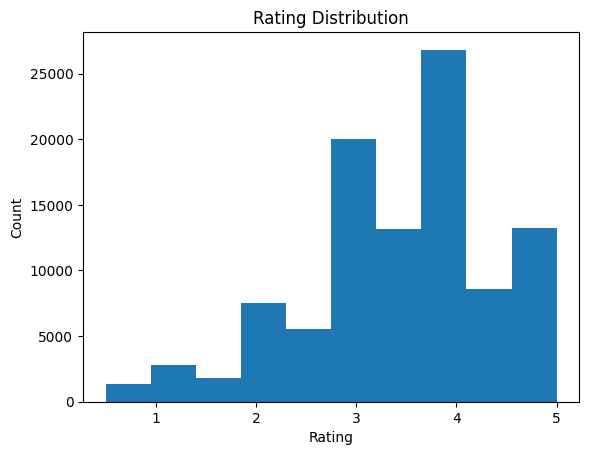

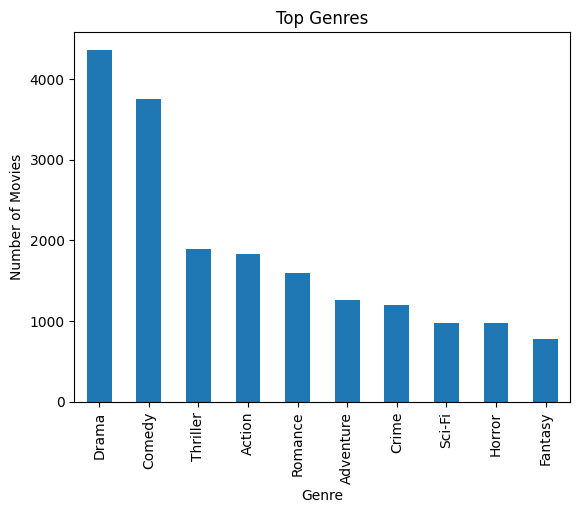

In [14]:
#Visualization
# Rating distribution
plt.hist(ratings['rating'], bins=10)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Top genres
genre_split = movies.copy()
genre_split['genres'] = genre_split['genres'].str.split('|')
genre_split = genre_split.explode('genres')
genre_counts = genre_split['genres'].value_counts().head(10)

genre_counts.plot(kind='bar')
plt.title('Top Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()


In [ ]:
so this is my project.

In [1]:
a=1+2
print(a)

3
